In [1]:
!pip install -q optuna

     |████████████████████████████████| 308 kB 9.7 MB/s 
     |████████████████████████████████| 209 kB 67.1 MB/s 
     |████████████████████████████████| 80 kB 12.0 MB/s 
     |████████████████████████████████| 75 kB 5.5 MB/s 
     |████████████████████████████████| 112 kB 79.1 MB/s 
     |████████████████████████████████| 49 kB 8.1 MB/s 
     |████████████████████████████████| 149 kB 78.7 MB/s 


In [3]:
import sys

!test -d nlp_repo && echo "FYI: nlp_repo directory already exists, to pull latest version uncomment this line: !rm -r nlp_repo"
# !rm -r nlp_repo # Uncomment if you need a clean pull from repo
!test -d nlp_repo || git clone https://github.com/huawei-university/nlp-assignment-2 nlp_repo
if not 'nlp_repo' in sys.path:
    sys.path += ['nlp_repo']

Cloning into 'nlp_repo'...
remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 21 (delta 7), reused 13 (delta 3), pack-reused 0
Unpacking objects: 100% (21/21), done.


In [4]:
%load_ext autoreload
%autoreload 2
import os
import csv
from random import seed
from pathlib import Path
from itertools import chain
import torch
from tqdm import tqdm
from IPython.display import HTML, display
import gensim.downloader as api
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pack_sequence
from data_preprocessing import read_data,read_test, Tokenizer, TextDataset,\
    Vocab,train_test_split
from utils import show_example
from model import prepare_emb_matrix, RecurrentClassifier
from trainer import Trainer
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Exploration

In [62]:

df = pd.read_csv('train.csv')
print(df.shape) 
df = df.drop_duplicates(subset=['comment_text'])
print(df.shape) 
stop = set(stopwords.words('english') + list(STOPWORDS))
df['comment_text'] = df['comment_text'].apply(lambda x: ' '.join([word for word in set(str(x).split()) if word not in (stop) and len(word)>1]))
df['comment_text'][34576] = df['comment_text'][34576][881:901] + 'huy fuck time kids think mother'
df.to_csv('data/cleaned_train.csv', index=False)
df.head()

(34647, 3)
(34581, 3)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


,id,comment_text,toxicity
0,0,righteous fuck creep self,3
1,1,pay goddam vandalism hell stop,2
2,2,something deliberately cnn unbiased well world...,0
3,3,article unsure link verfiability editor vanna ...,0
4,4,either consensus assumed admin posting grievan...,0


<function matplotlib.pyplot.show>

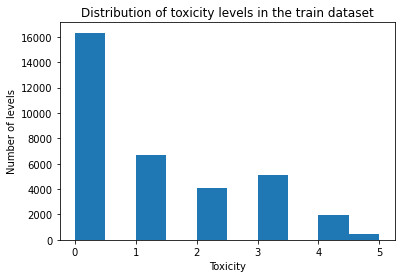

In [11]:
plt.xlabel('Toxicity')
plt.ylabel('Number of levels')
plt.hist(df["toxicity"])
plt.title('Distribution of toxicity levels in the train dataset')
plt.show

In [64]:
data = read_data('data/cleaned_train.csv')
seed(4)

# change this at your own risk 
ratings_to_show = (0, 1, 2)
display(HTML(show_example(data, ratings=ratings_to_show)))       

Toxicity,Comment,😇,editors congratulations credibility made sinking orwellian leftist submarine alreadly drudge torpedoed page low home wikipedia,😐,sad loser may bother voted terrifed eyed riorob brown little unelectable unemployed arguing freak benefits recepient autistic welfare one loosing,😧,actual consensus disscrimination jsut becuase bad lie friendly negatively accusing redefinition real arrogance ing anything responded picked accusations pretty strive opposed ok give stand concerned noddlinesses brush extreme reference unsourced toss focus continue interest statement shit make discrimination three feeling said making action head irrationality bit advice worthy edit refering vandal...


In [65]:
tok = Tokenizer()
tok_texts = [tok.tokenize(t) for t in chain(*data.values())]
vocab = Vocab(tok_texts, max_vocab_size=30000)

In [66]:
train_texts, train_labels, val_texts, val_labels = train_test_split(data)
train_dataset = TextDataset([tok.tokenize(t) for t in train_texts], train_labels, vocab)
val_dataset = TextDataset([tok.tokenize(t) for t in val_texts], val_labels, vocab)

In [67]:
# store embeddings in current directory
os.environ["GENSIM_DATA_DIR"] = str(Path.cwd())
# will download embeddings or load them from disk
gensim_model = api.load("glove-wiki-gigaword-100")
emb_matrix = prepare_emb_matrix(gensim_model, vocab)

[==================================================] 100.0% 128.1/128.1MB downloaded


In [70]:
config = {
    "freeze": True,
    "cell_type": "GRU",
    "cell_dropout": 0.3,
    "num_layers": 2,
    "hidden_size": 128,
    "out_activation": "relu",
    "bidirectional": False,
    "out_dropout": 0.2,
    "out_sizes": [200],
}

trainer_config = {
    "lr": 3e-4,
    "n_epochs": 10,
    "weight_decay": 1e-6,
    "batch_size": 128,
    "device": "cuda" if torch.cuda.is_available() else "cpu"
}
clf_model = RecurrentClassifier(config, vocab, emb_matrix)


## Training the Baseline Model

In [72]:
train_dataloader = DataLoader(train_dataset, 
                              batch_size=trainer_config["batch_size"],
                              shuffle=True,
                              num_workers=1,
                              collate_fn=train_dataset.collate_fn)
val_dataloader = DataLoader(val_dataset, 
                            batch_size=trainer_config["batch_size"],
                            shuffle=False,
                            num_workers=1,
                            collate_fn=val_dataset.collate_fn)
t = Trainer(trainer_config)
t.fit(clf_model, train_dataloader, val_dataloader)
t.save("baseline_model.ckpt")
t = Trainer.load("baseline_model.ckpt")

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

In [73]:
def predict_toxicity(model, comment):
    tok_text = tok.tokenize(comment)
    indexed_text = torch.tensor(vocab.vectorize(tok_text)).to(t.device)
    rating = model(pack_sequence([indexed_text])).argmax().item()
    print(f"Toxicity rating for \"{comment}\" is: {rating}") 

predict_toxicity(t.model, "Please sir do not delete my edits")
predict_toxicity(t.model, "They are nazi pal, forget it")
predict_toxicity(t.model, "You suck")

Toxicity rating for "Please sir do not delete my edits" is: 0
Toxicity rating for "They are nazi pal, forget it" is: 1
Toxicity rating for "You suck" is: 4


In [80]:
test_uuids, test_texts = read_test("data/test.csv")
test_dataloader = DataLoader(TextDataset([tok.tokenize(t) for t in test_texts], [-1] * len(test_texts), vocab), 
                            batch_size=trainer_config["batch_size"],
                            shuffle=False,
                            num_workers=8,
                            collate_fn=val_dataset.collate_fn)

predictions = t.predict(test_dataloader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [81]:
predictions

array([0, 0, 0, ..., 2, 1, 2])

In [82]:
sub = pd.read_csv("submission.csv")
sub['prediction'] = predictions 
sub.to_csv('submission12.csv', index=False)

## Automatic Hyperparameter Tuning with Optuna

In [ ]:
from optuna import create_study
from pprint import pprint


BEST_ACC = 0.0

def objective(trial):
    global BEST_ACC
    
    n_hidden_layers = trial.suggest_int("n_hidden_layers", 0, 3)
    hidden_layer_size = trial.suggest_int("hidden_layer_size", 10, 1000)
    
    config = {
        "freeze": True,
        "cell_type": trial.suggest_categorical("cell_type", ["RNN", "LSTM", "GRU"]),
        "cell_dropout": trial.suggest_loguniform("cell_dropout", 1e-9, 0.9),
        "num_layers": trial.suggest_int("num_layers", 1, 3),
        "hidden_size": trial.suggest_int("hidden_size", 10, 1000),
        "out_activation": trial.suggest_categorical("out_activation", 
                                                    ["sigmoid", "tanh", "relu", "elu"]),
        "bidirectional": trial.suggest_categorical("bidirectional", [True, False]),
        "out_dropout": trial.suggest_loguniform("out_dropout", 1e-9, 0.9),
        "out_sizes": [hidden_layer_size] * n_hidden_layers,
    }

    trainer_config = {
        "lr": trial.suggest_loguniform("lr", 1e-5, 1e-3),
        "n_epochs": 10,
        "weight_decay": trial.suggest_loguniform("weight_decay", 1e-9, 1e-1),
        "batch_size": 128,
        "device": "cuda" if torch.cuda.is_available() else "cpu",
        "verbose": False,
    }
    
    pprint({**config, **trainer_config})
        
    clf_model = RecurrentClassifier(config, vocab, emb_matrix)
    t = Trainer(trainer_config)
    t.fit(clf_model, train_dataloader, val_dataloader)
    val_acc =  t.history["val_acc"][-1]
    if val_acc > BEST_ACC:
        BEST_ACC = val_acc
        t.save("optuna_model.ckpt")
    return val_acc

In [ ]:
study = create_study(direction="maximize")
# you can set more trials
study.optimize(objective, n_trials=10)

[I 2021-11-27 06:42:11,804] A new study created in memory with name: no-name-8e67b327-f96d-4e3d-b92e-ed0b28882023


{'batch_size': 128,
 'bidirectional': True,
 'cell_dropout': 1.2415506572224005e-09,
 'cell_type': 'LSTM',
 'device': 'cuda',
 'freeze': True,
 'hidden_size': 459,
 'lr': 0.0005313634184828698,
 'n_epochs': 10,
 'num_layers': 3,
 'out_activation': 'tanh',
 'out_dropout': 2.190564837498314e-08,
 'out_sizes': [],
 'verbose': False,
 'weight_decay': 1.543913773942862e-08}


[I 2021-11-27 07:00:02,651] Trial 0 finished with value: 0.6664739847183228 and parameters: {'n_hidden_layers': 0, 'hidden_layer_size': 261, 'cell_type': 'LSTM', 'cell_dropout': 1.2415506572224005e-09, 'num_layers': 3, 'hidden_size': 459, 'out_activation': 'tanh', 'bidirectional': True, 'out_dropout': 2.190564837498314e-08, 'lr': 0.0005313634184828698, 'weight_decay': 1.543913773942862e-08}. Best is trial 0 with value: 0.6664739847183228.


{'batch_size': 128,
 'bidirectional': False,
 'cell_dropout': 0.7003056891826371,
 'cell_type': 'LSTM',
 'device': 'cuda',
 'freeze': True,
 'hidden_size': 98,
 'lr': 0.00021861372266790324,
 'n_epochs': 10,
 'num_layers': 3,
 'out_activation': 'sigmoid',
 'out_dropout': 0.0061738226514519625,
 'out_sizes': [981, 981, 981],
 'verbose': False,
 'weight_decay': 0.0009225157162840679}


[I 2021-11-27 07:04:33,016] Trial 1 finished with value: 0.6668593287467957 and parameters: {'n_hidden_layers': 3, 'hidden_layer_size': 981, 'cell_type': 'LSTM', 'cell_dropout': 0.7003056891826371, 'num_layers': 3, 'hidden_size': 98, 'out_activation': 'sigmoid', 'bidirectional': False, 'out_dropout': 0.0061738226514519625, 'lr': 0.00021861372266790324, 'weight_decay': 0.0009225157162840679}. Best is trial 1 with value: 0.6668593287467957.


{'batch_size': 128,
 'bidirectional': True,
 'cell_dropout': 0.08016428729705179,
 'cell_type': 'RNN',
 'device': 'cuda',
 'freeze': True,
 'hidden_size': 773,
 'lr': 2.5524197489510532e-05,
 'n_epochs': 10,
 'num_layers': 3,
 'out_activation': 'relu',
 'out_dropout': 0.8954668305449339,
 'out_sizes': [253, 253, 253],
 'verbose': False,
 'weight_decay': 1.0507118442499005e-09}


[I 2021-11-27 07:19:19,763] Trial 2 finished with value: 0.6423892378807068 and parameters: {'n_hidden_layers': 3, 'hidden_layer_size': 253, 'cell_type': 'RNN', 'cell_dropout': 0.08016428729705179, 'num_layers': 3, 'hidden_size': 773, 'out_activation': 'relu', 'bidirectional': True, 'out_dropout': 0.8954668305449339, 'lr': 2.5524197489510532e-05, 'weight_decay': 1.0507118442499005e-09}. Best is trial 1 with value: 0.6668593287467957.


{'batch_size': 128,
 'bidirectional': False,
 'cell_dropout': 2.5853477356858104e-09,
 'cell_type': 'RNN',
 'device': 'cuda',
 'freeze': True,
 'hidden_size': 517,
 'lr': 0.00012430863536621646,
 'n_epochs': 10,
 'num_layers': 1,
 'out_activation': 'elu',
 'out_dropout': 2.2742440601336926e-06,
 'out_sizes': [608, 608, 608],
 'verbose': False,
 'weight_decay': 0.00012338252685015718}


[I 2021-11-27 07:20:58,038] Trial 3 finished with value: 0.6225433349609375 and parameters: {'n_hidden_layers': 3, 'hidden_layer_size': 608, 'cell_type': 'RNN', 'cell_dropout': 2.5853477356858104e-09, 'num_layers': 1, 'hidden_size': 517, 'out_activation': 'elu', 'bidirectional': False, 'out_dropout': 2.2742440601336926e-06, 'lr': 0.00012430863536621646, 'weight_decay': 0.00012338252685015718}. Best is trial 1 with value: 0.6668593287467957.


{'batch_size': 128,
 'bidirectional': True,
 'cell_dropout': 0.0004942867311174135,
 'cell_type': 'LSTM',
 'device': 'cuda',
 'freeze': True,
 'hidden_size': 979,
 'lr': 0.0002716952728444843,
 'n_epochs': 10,
 'num_layers': 3,
 'out_activation': 'relu',
 'out_dropout': 4.5175024178807184e-05,
 'out_sizes': [948, 948],
 'verbose': False,
 'weight_decay': 3.3701610230137165e-08}


[I 2021-11-27 07:54:47,437] Trial 4 finished with value: 0.6630057692527771 and parameters: {'n_hidden_layers': 2, 'hidden_layer_size': 948, 'cell_type': 'LSTM', 'cell_dropout': 0.0004942867311174135, 'num_layers': 3, 'hidden_size': 979, 'out_activation': 'relu', 'bidirectional': True, 'out_dropout': 4.5175024178807184e-05, 'lr': 0.0002716952728444843, 'weight_decay': 3.3701610230137165e-08}. Best is trial 1 with value: 0.6668593287467957.


{'batch_size': 128,
 'bidirectional': True,
 'cell_dropout': 0.009963940435733652,
 'cell_type': 'GRU',
 'device': 'cuda',
 'freeze': True,
 'hidden_size': 52,
 'lr': 1.4115233531962665e-05,
 'n_epochs': 10,
 'num_layers': 1,
 'out_activation': 'sigmoid',
 'out_dropout': 0.0331972633715243,
 'out_sizes': [],
 'verbose': False,
 'weight_decay': 1.1345457916851405e-06}


[I 2021-11-27 07:56:47,545] Trial 5 finished with value: 0.5516377687454224 and parameters: {'n_hidden_layers': 0, 'hidden_layer_size': 468, 'cell_type': 'GRU', 'cell_dropout': 0.009963940435733652, 'num_layers': 1, 'hidden_size': 52, 'out_activation': 'sigmoid', 'bidirectional': True, 'out_dropout': 0.0331972633715243, 'lr': 1.4115233531962665e-05, 'weight_decay': 1.1345457916851405e-06}. Best is trial 1 with value: 0.6668593287467957.


{'batch_size': 128,
 'bidirectional': True,
 'cell_dropout': 0.11407374781185986,
 'cell_type': 'LSTM',
 'device': 'cuda',
 'freeze': True,
 'hidden_size': 69,
 'lr': 2.7075619231949453e-05,
 'n_epochs': 10,
 'num_layers': 2,
 'out_activation': 'tanh',
 'out_dropout': 0.0016793515314449104,
 'out_sizes': [702],
 'verbose': False,
 'weight_decay': 0.009199584652647618}


[I 2021-11-27 08:01:50,491] Trial 6 finished with value: 0.6154142618179321 and parameters: {'n_hidden_layers': 1, 'hidden_layer_size': 702, 'cell_type': 'LSTM', 'cell_dropout': 0.11407374781185986, 'num_layers': 2, 'hidden_size': 69, 'out_activation': 'tanh', 'bidirectional': True, 'out_dropout': 0.0016793515314449104, 'lr': 2.7075619231949453e-05, 'weight_decay': 0.009199584652647618}. Best is trial 1 with value: 0.6668593287467957.


{'batch_size': 128,
 'bidirectional': False,
 'cell_dropout': 0.00022210977605434908,
 'cell_type': 'RNN',
 'device': 'cuda',
 'freeze': True,
 'hidden_size': 981,
 'lr': 8.404756422239392e-05,
 'n_epochs': 10,
 'num_layers': 3,
 'out_activation': 'tanh',
 'out_dropout': 0.0007578540761479812,
 'out_sizes': [],
 'verbose': False,
 'weight_decay': 6.996560586854292e-07}


[I 2021-11-27 08:09:57,166] Trial 7 finished with value: 0.6059730052947998 and parameters: {'n_hidden_layers': 0, 'hidden_layer_size': 549, 'cell_type': 'RNN', 'cell_dropout': 0.00022210977605434908, 'num_layers': 3, 'hidden_size': 981, 'out_activation': 'tanh', 'bidirectional': False, 'out_dropout': 0.0007578540761479812, 'lr': 8.404756422239392e-05, 'weight_decay': 6.996560586854292e-07}. Best is trial 1 with value: 0.6668593287467957.


{'batch_size': 128,
 'bidirectional': False,
 'cell_dropout': 2.0608685186071296e-08,
 'cell_type': 'GRU',
 'device': 'cuda',
 'freeze': True,
 'hidden_size': 877,
 'lr': 7.153517409239707e-05,
 'n_epochs': 10,
 'num_layers': 1,
 'out_activation': 'elu',
 'out_dropout': 0.213136659919331,
 'out_sizes': [],
 'verbose': False,
 'weight_decay': 1.0777127756554927e-09}


[I 2021-11-27 08:13:18,530] Trial 8 finished with value: 0.665895938873291 and parameters: {'n_hidden_layers': 0, 'hidden_layer_size': 387, 'cell_type': 'GRU', 'cell_dropout': 2.0608685186071296e-08, 'num_layers': 1, 'hidden_size': 877, 'out_activation': 'elu', 'bidirectional': False, 'out_dropout': 0.213136659919331, 'lr': 7.153517409239707e-05, 'weight_decay': 1.0777127756554927e-09}. Best is trial 1 with value: 0.6668593287467957.


{'batch_size': 128,
 'bidirectional': True,
 'cell_dropout': 0.042573625451857396,
 'cell_type': 'RNN',
 'device': 'cuda',
 'freeze': True,
 'hidden_size': 43,
 'lr': 0.00041818941506078903,
 'n_epochs': 10,
 'num_layers': 3,
 'out_activation': 'elu',
 'out_dropout': 9.734365174556251e-08,
 'out_sizes': [68, 68, 68],
 'verbose': False,
 'weight_decay': 7.961576340749111e-07}


[I 2021-11-27 08:20:20,744] Trial 9 finished with value: 0.6516377925872803 and parameters: {'n_hidden_layers': 3, 'hidden_layer_size': 68, 'cell_type': 'RNN', 'cell_dropout': 0.042573625451857396, 'num_layers': 3, 'hidden_size': 43, 'out_activation': 'elu', 'bidirectional': True, 'out_dropout': 9.734365174556251e-08, 'lr': 0.00041818941506078903, 'weight_decay': 7.961576340749111e-07}. Best is trial 1 with value: 0.6668593287467957.


In [ ]:
t = Trainer.load("optuna_model.ckpt")
preds = t.predict(test_dataloader)
sub = pd.read_csv("submission.csv")
sub['prediction'] = predictions 
sub.to_csv('submission13.csv', index=False)